In [1]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
!ls ../input/flight-delay-dataset-20182022/ | grep parquet

Combined_Flights_2018.parquet
Combined_Flights_2019.parquet
Combined_Flights_2020.parquet
Combined_Flights_2021.parquet
Combined_Flights_2022.parquet


In [3]:
columns_interested = ['FlightDate','Airline', 'Origin', 'Dest', 'Cancelled', 'Diverted', 'DepDelayMinutes',
       'ArrDelayMinutes','Distance', 'Year', 'Month', 'DayofMonth', 'DayOfWeek','Tail_Number']

In [4]:
years = [2018]#, 2019, 2020, 2021, 2022]
allFlights = []
for year in years:
    fileName = f"Combined_Flights_{year}"
    directoryName = "/kaggle/input/flight-delay-dataset-20182022/"+fileName+".parquet"
    allFlights.append(pd.read_parquet(directoryName,columns = columns_interested))
df = pd.concat(allFlights).reset_index(drop=True)
df = df.dropna()
del allFlights

In [5]:
df['Airline'] =  df['Airline'].astype(dtype='string')
df['Origin'] =  df['Origin'].astype(dtype='string')
df['Dest'] =  df['Dest'].astype(dtype='string')
df['Tail_Number'] =  df['Tail_Number'].astype(dtype='string')

In [6]:
df.dtypes

FlightDate         datetime64[ns]
Airline                    string
Origin                     string
Dest                       string
Cancelled                    bool
Diverted                     bool
DepDelayMinutes           float64
ArrDelayMinutes           float64
Distance                  float64
Year                        int64
Month                       int64
DayofMonth                  int64
DayOfWeek                   int64
Tail_Number                string
dtype: object

## Both arrival and departures delays have exponential distributions.

<AxesSubplot:title={'center':'Arrival Delays'}, ylabel='Frequency'>

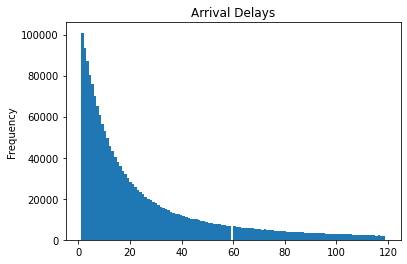

In [7]:
df.loc[(df['ArrDelayMinutes'] > 0.0) & (df['ArrDelayMinutes'] < 120.0)]['ArrDelayMinutes'].plot(kind='hist',bins=120, title="Arrival Delays")

<AxesSubplot:title={'center':'Departure Delays'}, ylabel='Frequency'>

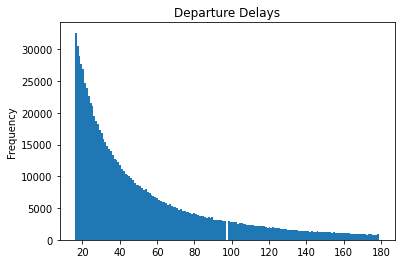

In [8]:
df.loc[(df['DepDelayMinutes'] > 15.0) & (df['DepDelayMinutes'] < 180.0)]['DepDelayMinutes'].plot(kind='hist',bins=165,title="Departure Delays")

According to FAA a flight is considered to be delayed when it is 15 minutes later than its scheduled time.

# Q: Which airports had the longest arrival and departure delays?

<AxesSubplot:title={'center':'Airports with most delays between 2018 and 2022'}, ylabel='Origin'>

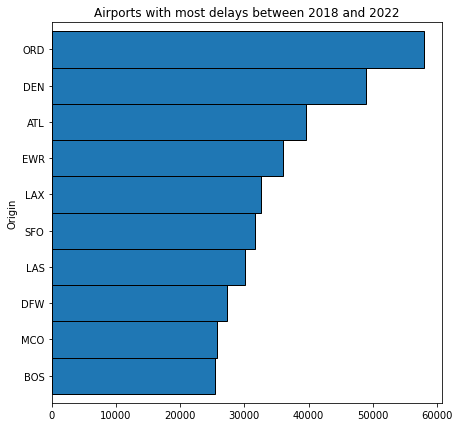

In [9]:
_df = df.loc[(df['DepDelayMinutes']>=15.0)].groupby('Origin').size().sort_values(ascending=True)
_df.tail(n=10).plot(kind = 'barh',figsize=(7,7), title="Airports with most delays between 2018 and 2022", ylabel="Sum of all delays in minutes", width=1, edgecolor="black")

<AxesSubplot:title={'center':'Most arrival delays per airport'}, ylabel='Dest'>

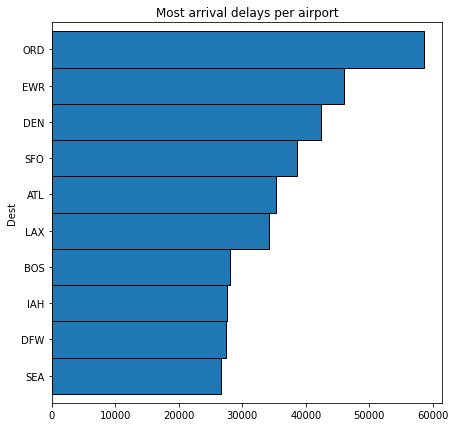

In [10]:
_df = df.loc[(df['ArrDelayMinutes']>=15.0)].groupby('Dest').size().sort_values(ascending=True)
_df.tail(n=10).plot(kind = 'barh',figsize=(7,7), title="Most arrival delays per airport",edgecolor = 'black', width=1)

**Chicago O'Hare, Denver, Dallas, Atlanta** airports had the highest cumulative delays both in arrival and departure.

# Q: Which airports had the highest percentage of delayed arrival and departure flights?

YNG is a military airport. There is only 2 data points associated with it in the dataset.

In [11]:
df.drop(df[df['Origin'] == 'YNG'].index, inplace = True)
df.drop(df[df['Dest'] == 'YNG'].index, inplace = True)
df['ArrDelay15Min'] = (df['ArrDelayMinutes']>=15.0)#.groupby('Dest').size().sort_values(ascending=True)
_df = df.groupby(['Dest','ArrDelay15Min']).size()
_df = _df.to_frame(name = 'size').reset_index()
_df['percentages'] = _df.groupby('Dest').apply(lambda x:100 * x / x.sum())['size']

<AxesSubplot:ylabel='Arrivals'>

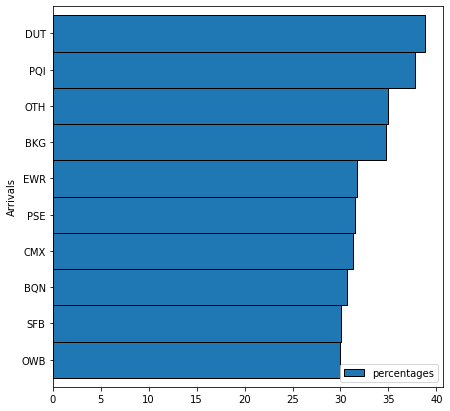

In [12]:
_df.loc[_df['ArrDelay15Min']==True].sort_values(by='percentages',ascending=True).tail(10).plot(kind='barh', x='Dest',y='percentages',ylabel="Percentage of arrivals delayed",xlabel="Arrivals",edgecolor = 'black', width=1,figsize=(7,7))

In [13]:
df['DepDelay15Min'] = (df['DepDelayMinutes']>=15.0)
_df = df.groupby(['Origin','DepDelay15Min']).size()
_df = _df.to_frame(name = 'size').reset_index()
_df['percentages'] = _df.groupby('Origin').apply(lambda x:100 * x / x.sum())['size']

<AxesSubplot:ylabel='Origin'>

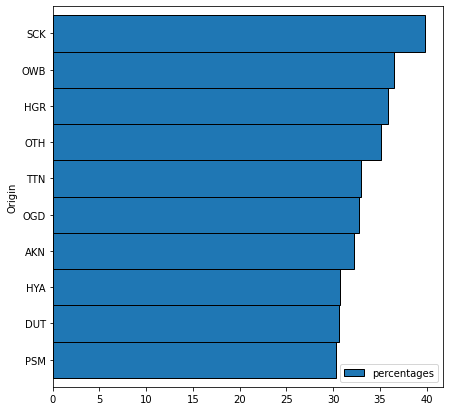

In [14]:
_df.loc[_df['DepDelay15Min']==True].sort_values(by='percentages',ascending=True).tail(10).plot(kind='barh', x='Origin',y='percentages',ylabel="Percentage of departures delayed",xlabel="Origin",figsize=(7,7),width=1,edgecolor='black')

Most of these are small, regional airports.


# Q: Which airlines' flights were delayed for longest amount of time?

<AxesSubplot:title={'center':'Carriers with most delays between 2018 and 2022'}, ylabel='Airline'>

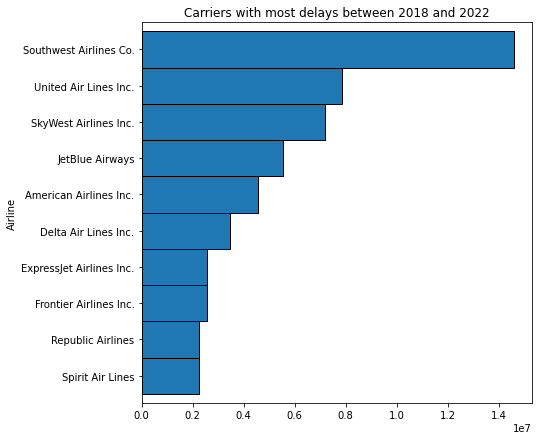

In [15]:
_df = df.loc[(df['DepDelayMinutes']>=15.0)].groupby('Airline')["DepDelayMinutes"].sum().sort_values(ascending=True)
_df.tail(n=10).plot(kind = 'barh', title="Carriers with most delays between 2018 and 2022", ylabel="Sum of all delays in minutes",figsize=(7,7),edgecolor = 'black',width=1)

# Q: Which airline was the most late?

<AxesSubplot:title={'center':'Carriers with most delays between 2018 and 2022'}, ylabel='Airline'>

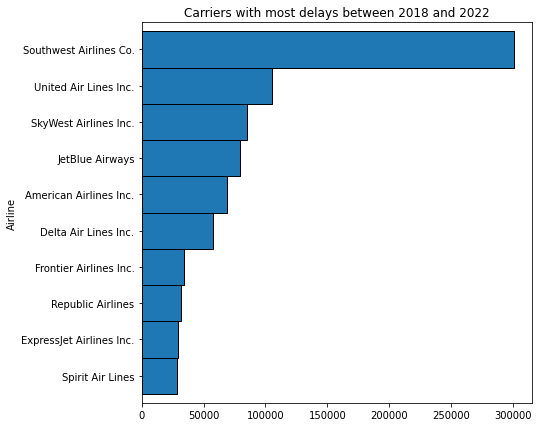

In [16]:
_df = df.loc[(df['DepDelayMinutes']>=15.0)].groupby('Airline')["DepDelayMinutes"].count().sort_values(ascending=True)
_df.tail(n=10).plot(kind = 'barh', title="Carriers with most delays between 2018 and 2022", ylabel="Sum of all delays in minutes", width=1, edgecolor='black',figsize=(7,7))

<AxesSubplot:ylabel='Airline'>

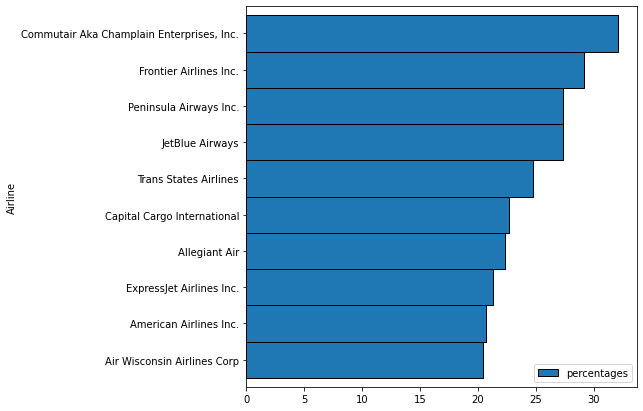

In [17]:
df['ArrDelay15Min'] = (df['ArrDelayMinutes']>=15.0)#.groupby('Dest').size().sort_values(ascending=True)
_df = df.groupby(['Airline','ArrDelay15Min']).size()
_df = _df.to_frame(name = 'size').reset_index()
_df['percentages'] = _df.groupby('Airline').apply(lambda x:100 * x / x.sum())['size']
_df.loc[_df['ArrDelay15Min']==True].sort_values(by='percentages',ascending=True).tail(10).plot(kind='barh', x='Airline',y='percentages',ylabel="Percentage of arrivals delayed",xlabel="Airline", width=1, edgecolor='black',figsize=(7,7))

<AxesSubplot:ylabel='Airline'>

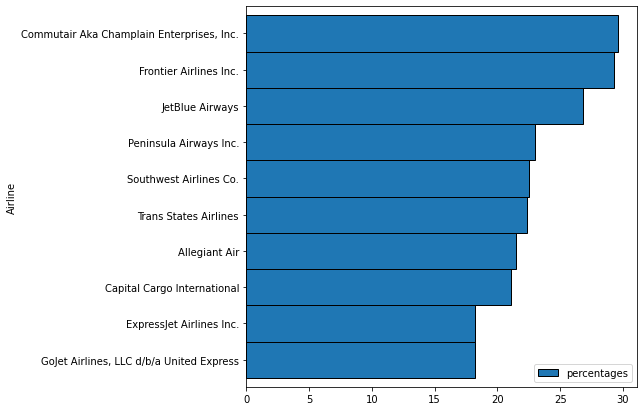

In [18]:
df['DeptDelay15Min'] = (df['DepDelayMinutes']>=15.0)#.groupby('Dest').size().sort_values(ascending=True)
_df = df.groupby(['Airline','DeptDelay15Min']).size()
_df = _df.to_frame(name = 'size').reset_index()
_df['percentages'] = _df.groupby('Airline').apply(lambda x:100 * x / x.sum())['size']
_df.loc[_df['DeptDelay15Min']==True].sort_values(by='percentages',ascending=True).tail(10).plot(kind='barh', x='Airline',y='percentages',ylabel="Percentage of departures delayed",xlabel="Airline",figsize=(7,7),width=1,edgecolor='black')

FAA divides delays into three groups

* "on time or small delay" (up to 15 minutes delay)

* "Medium delay" (15 – 45 minutes delay)

* "Large delay" ( 45 minutes delay)

In [19]:
df["DepDelayGroup"] = None
df.loc[df["DepDelayMinutes"] <= 15.0, "DepDelayGroup"] = "OnTimeOrSmall"
df.loc[(df["DepDelayMinutes"] <= 45.0)&(df["DepDelayMinutes"] > 15.0), "DepDelayGroup"] = "Medium"
df.loc[(df["DepDelayMinutes"] > 45.0), "DepDelayGroup"] = "Long"

In [20]:
df["ArrDelayGroup"] = None
df.loc[df["ArrDelayMinutes"] <= 15.0, "ArrDelayGroup"] = "OnTimeOrSmall"
df.loc[(df["ArrDelayMinutes"] <= 45.0)&(df["ArrDelayMinutes"] > 15.0), "ArrDelayGroup"] = "Medium"
df.loc[(df["ArrDelayMinutes"] > 45.0), "ArrDelayGroup"] = "Long"

<AxesSubplot:xlabel='Month'>

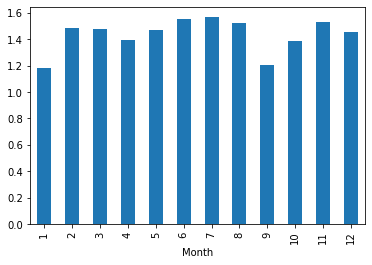

In [21]:
df.loc[df["ArrDelayGroup"] == "OnTimeOrSmall"].groupby("Month").mean()["ArrDelayMinutes"].plot(kind="bar")

<AxesSubplot:ylabel='Month'>

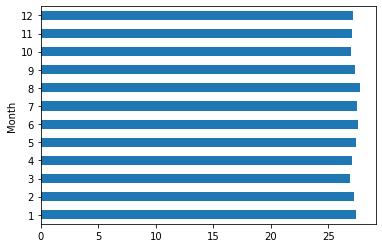

In [22]:
df.loc[df["ArrDelayGroup"] == "Medium"].groupby("Month").mean()["ArrDelayMinutes"].plot(kind="barh")

<AxesSubplot:ylabel='Month'>

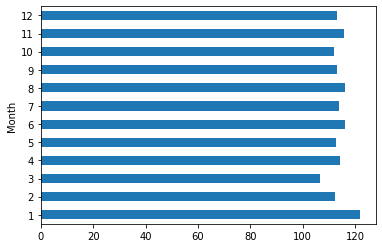

In [23]:
df.loc[df["ArrDelayGroup"] == "Long"].groupby("Month").mean()["ArrDelayMinutes"].plot(kind="barh")

<AxesSubplot:ylabel='Month'>

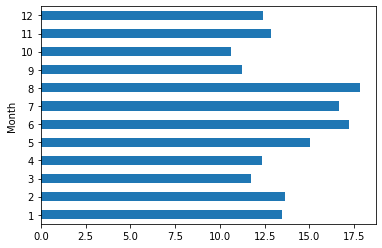

In [24]:
df.groupby("Month").mean()["DepDelayMinutes"].plot(kind="barh")

<AxesSubplot:xlabel='ArrDelayGroup'>

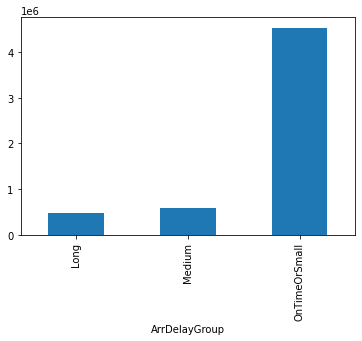

In [25]:
df.groupby("ArrDelayGroup")["ArrDelayGroup"].size().plot(kind='bar')

<AxesSubplot:xlabel='DepDelayGroup'>

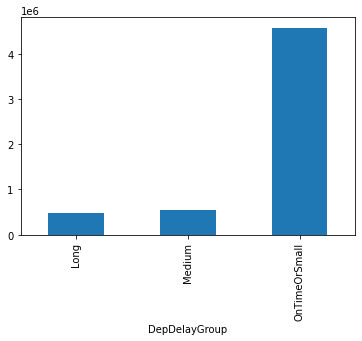

In [26]:
df.groupby("DepDelayGroup")["DepDelayGroup"].size().plot(kind='bar')